
# MLF Week 4: Neural Networks Part 2 - Training (Solutions)


Reference version with filled code.


## 0. Setup

In [1]:
from utils import *

import math, random, os, sys, time
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

torch.manual_seed(0); random.seed(0); np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')


## 1. Backpropagation (Intuition)


Autograd records the computation graph during the forward pass. Calling `loss.backward()` applies the chain rule through that graph and populates gradients for leaf tensors.

You have seen this in week one, when we use to compute the gradient manually.


### 1.1 Autograd mini demo

In [2]:
x = torch.tensor([2.0], requires_grad=True)
y = (3*x + 2)**2 / 2
y.backward()
print("dy/dx at x=2:", x.grad.item())


dy/dx at x=2: 24.0



## 2. Data (two moons)

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def make_toy_data(n_samples=1200, noise=0.2, test_size=0.2, seed=0):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    return (torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long),
            torch.tensor(X_val,   dtype=torch.float32),
            torch.tensor(y_val,   dtype=torch.long))

X_train, y_train, X_val, y_val = make_toy_data()
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
len(train_ds), len(val_ds)


(960, 240)

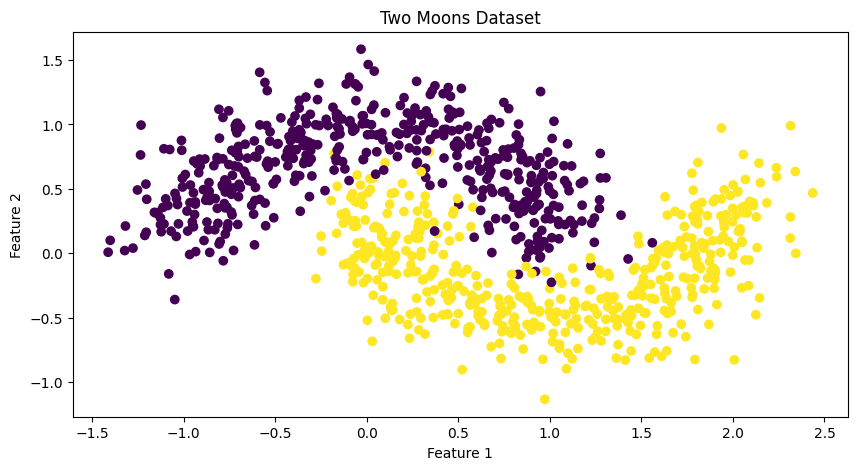

In [4]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Two Moons Dataset')
plt.show()


## 3. Model (MLP)
Let's build a sample 3 layer neural network.

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden_sizes=(32, 32), out_dim=2):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden_sizes:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


## 4. Training loop

In [6]:
def accuracy(model, loader, device=device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    return correct / max(1, total)

def train_model(model, train_loader, val_loader, epochs=50, lr=0.05, optimizer_name='sgd', device=device):
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, val_accs = [], [], []
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()

        train_losses.append(running / len(train_loader))

        model.eval()
        with torch.no_grad():
            vloss = 0.0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                vloss += criterion(model(xb), yb).item()
            vloss /= len(val_loader)
        val_losses.append(vloss)
        val_accs.append(accuracy(model, val_loader, device=device))

        print(f"Epoch {ep}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    return {"train_losses": train_losses, "val_losses": val_losses, "val_accs": val_accs}



## 5. Baseline run (SGD)

Epoch 1/50, Train Loss: 0.6210, Val Loss: 0.5614, Val Acc: 0.8542
Epoch 2/50, Train Loss: 0.5271, Val Loss: 0.4685, Val Acc: 0.8458
Epoch 3/50, Train Loss: 0.4476, Val Loss: 0.3930, Val Acc: 0.8417
Epoch 4/50, Train Loss: 0.3870, Val Loss: 0.3401, Val Acc: 0.8542
Epoch 5/50, Train Loss: 0.3468, Val Loss: 0.3044, Val Acc: 0.8583
Epoch 6/50, Train Loss: 0.3217, Val Loss: 0.2818, Val Acc: 0.8708
Epoch 7/50, Train Loss: 0.3043, Val Loss: 0.2663, Val Acc: 0.8750
Epoch 8/50, Train Loss: 0.2932, Val Loss: 0.2546, Val Acc: 0.8792
Epoch 9/50, Train Loss: 0.2839, Val Loss: 0.2465, Val Acc: 0.8875
Epoch 10/50, Train Loss: 0.2764, Val Loss: 0.2362, Val Acc: 0.8958
Epoch 11/50, Train Loss: 0.2731, Val Loss: 0.2316, Val Acc: 0.9000
Epoch 12/50, Train Loss: 0.2693, Val Loss: 0.2284, Val Acc: 0.9042
Epoch 13/50, Train Loss: 0.2658, Val Loss: 0.2222, Val Acc: 0.9167
Epoch 14/50, Train Loss: 0.2615, Val Loss: 0.2176, Val Acc: 0.9125
Epoch 15/50, Train Loss: 0.2582, Val Loss: 0.2144, Val Acc: 0.9167
Epoc

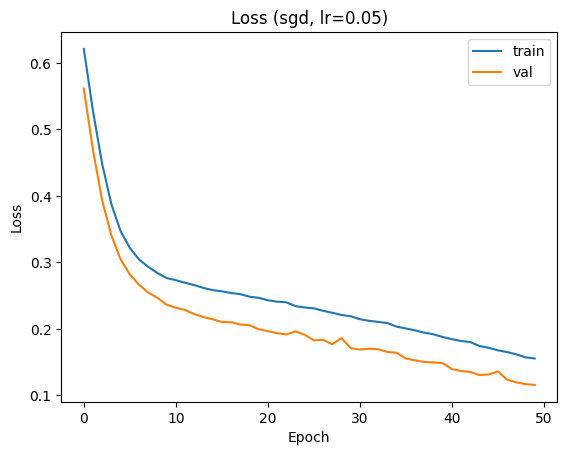

Validation accuracy: 0.9708


In [7]:
EPOCHS = 50
LR = 0.05
OPT = 'sgd'  # or 'adam'

model = MLP().to(device)
out = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, optimizer_name=OPT, device=device)

plt.figure()
plt.plot(out["train_losses"], label="train")
plt.plot(out["val_losses"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss ({OPT}, lr={LR})")
plt.legend(); plt.show()
print("Validation accuracy:", round(out["val_accs"][-1], 4))


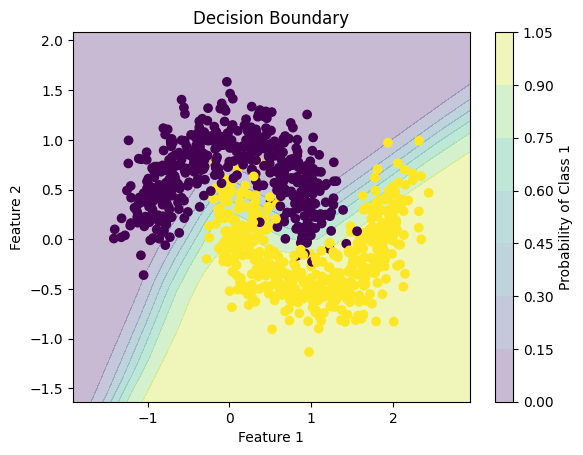

In [8]:
# Plot the decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    with torch.no_grad():
        # Fix: Convert numpy arrays to tensors properly
        Xgrid = torch.stack([torch.from_numpy(xx.ravel()), torch.from_numpy(yy.ravel())], dim=1).float()
        Xgrid = Xgrid.to(device)  # Move to device
        logits = model(Xgrid)
        # Fix: Use softmax for multi-class, then take probability of class 1
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probability of class 1
        Z = probs.cpu().view(xx.shape)  # Move back to CPU for plotting

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.colorbar(label='Probability of Class 1')

plot_decision_boundary(model, X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.title('Decision Boundary'); plt.show()



## 6. Optimizers (comparison)

Epoch 1/200, Train Loss: 0.6601, Val Loss: 0.6510, Val Acc: 0.5000
Epoch 2/200, Train Loss: 0.6438, Val Loss: 0.6344, Val Acc: 0.5250
Epoch 3/200, Train Loss: 0.6284, Val Loss: 0.6189, Val Acc: 0.5875
Epoch 4/200, Train Loss: 0.6141, Val Loss: 0.6040, Val Acc: 0.7667
Epoch 5/200, Train Loss: 0.6004, Val Loss: 0.5896, Val Acc: 0.8208
Epoch 6/200, Train Loss: 0.5868, Val Loss: 0.5753, Val Acc: 0.8500
Epoch 7/200, Train Loss: 0.5733, Val Loss: 0.5609, Val Acc: 0.8375
Epoch 8/200, Train Loss: 0.5597, Val Loss: 0.5465, Val Acc: 0.8417
Epoch 9/200, Train Loss: 0.5463, Val Loss: 0.5322, Val Acc: 0.8417
Epoch 10/200, Train Loss: 0.5328, Val Loss: 0.5179, Val Acc: 0.8292
Epoch 11/200, Train Loss: 0.5196, Val Loss: 0.5038, Val Acc: 0.8333
Epoch 12/200, Train Loss: 0.5066, Val Loss: 0.4900, Val Acc: 0.8333
Epoch 13/200, Train Loss: 0.4939, Val Loss: 0.4765, Val Acc: 0.8333
Epoch 14/200, Train Loss: 0.4816, Val Loss: 0.4634, Val Acc: 0.8292
Epoch 15/200, Train Loss: 0.4697, Val Loss: 0.4509, Val A

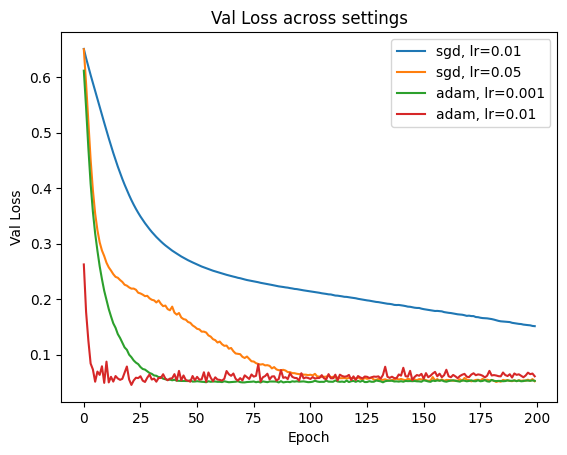

In [13]:
settings = [
    ('sgd', 0.01, 30),
    ('sgd', 0.05, 30),
    ('adam', 0.001, 30),
    ('adam', 0.01, 30),
]

plt.figure()
for opt, lr, epochs in settings:
    model = MLP().to(device)
    out = train_model(model, train_loader, val_loader, epochs=200, lr=lr, optimizer_name=opt, device=device)
    plt.plot(out["val_losses"], label=f"{opt}, lr={lr}")
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Val Loss across settings"); plt.legend(); plt.show()
